In [231]:
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns

import numpy as np
import pandas as pd 

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score ,confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn import set_config

In [232]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

set_config(display="diagram")

##### Estamos utilizando um dataset para discriminação de vozes masculinas e femininas. https://www.kaggle.com/datasets/primaryobjects/voicegender

##### Este é um dataset para classificação.

# Importando dataset

In [233]:
df = pd .read_csv('../input/voice.csv')

##### É importante conhecer o formato dos dados que estamos lidando. O dataset possui 3168 amostras com 20 features para a classificação e uma coluna de labels

In [234]:
Nsamples, Nfeatures = df.shape
print(f'Nsamples:{Nsamples}\nNfeatures: {Nfeatures}')
df.head()

Nsamples:3168
Nfeatures: 21


,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


## Encoding dos Labels

##### As classes estão definidas como 'male' e 'female', entretanto para o treinamento necessitamos que esse valores sejam variáveis inteiras discretas. Para isso estruturamos um encoding das classes onde a classe 'male' se torna 0 e a classe 'female' 1

In [235]:
print(df.label.value_counts())
dict = {'male':0,'female':1}
df.label.replace(dict,inplace = True)
df.head()

male      1584
female    1584
Name: label, dtype: int64


,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,0
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,0
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,0
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,0
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,0


##### Como o número de amostras entre as classes são iguais não será utilizar técnicas de balanceamento de classes como SMOTE ou Bootstrapping na validação.

## Correlação de Features 

<AxesSubplot:>

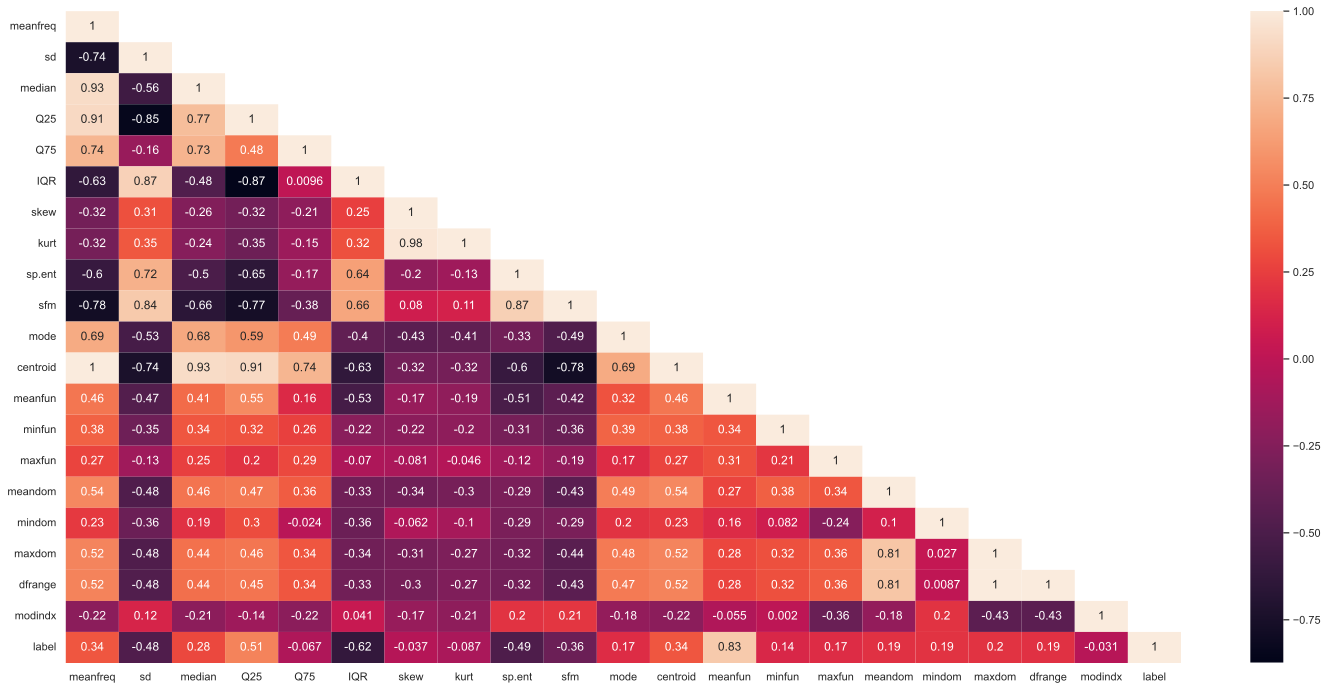

In [236]:
sns.set(style='whitegrid',color_codes=True)
cor_mat= df.corr(method='pearson')
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False ## triangular inferior
fig=plt.gcf()
fig.set_size_inches(25,12)
sns.heatmap(data=cor_mat,mask=mask,annot=True,cbar=True)

##### É possível observar que algumas das features são linearmente correlacionadas. Isso fornece índicios que é possível realizar uma redução de dimensionalidade para diminuir a redundância de features.

Temos como hipótese que as seguintes features são equivalentes:
- MeanFreq $\approx$ Centroid
- dfrange $\approx$ maxdom

##### É interessante visualizar algumas das caracteristicas do dataset

In [237]:
def plot_male_female(feature):
    sns.catplot(data=df,y=feature, x='label',kind='box')
    fig=plt.gcf()
    fig.set_size_inches(10,10)

##### Homens tendem a ter uma frequência média da voz mais baixa, i.e, grave.

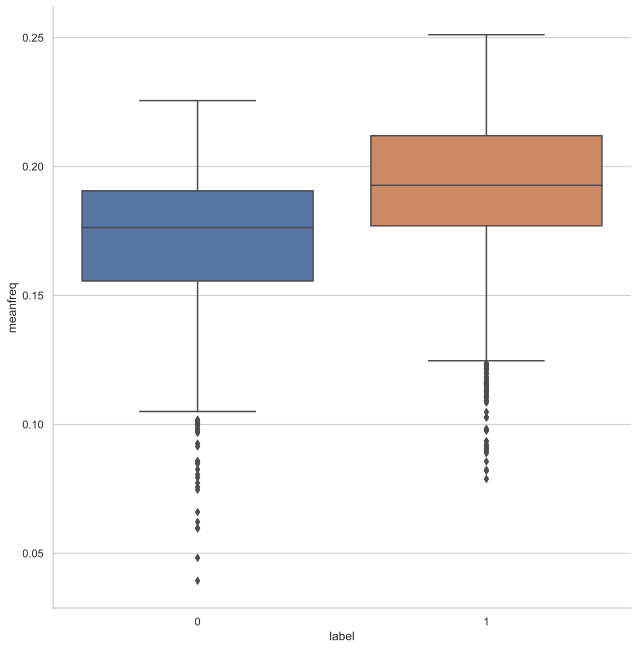

In [238]:
plot_male_female('meanfreq')

## Checando por valores de feature nulos 

##### Não podemos alimentar os modelos com valores nulos, portanto precisamos validar se alguma das amostras do dataset apresenta features nulas.

In [239]:
df.isnull().sum()

meanfreq    0
sd          0
median      0
Q25         0
Q75         0
IQR         0
skew        0
kurt        0
sp.ent      0
sfm         0
mode        0
centroid    0
meanfun     0
minfun      0
maxfun      0
meandom     0
mindom      0
maxdom      0
dfrange     0
modindx     0
label       0
dtype: int64

##### Nenhuma das features possui valores nulos, portanto não cabe nenhum tratamento.
##### Porém, se fosse o caso poderiamos utilizar um [SimpleInputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) para substituir os valores ou simplesmente descartá-los

## Separação Amostras e Labels

##### O dataset possui as colunas das features mais a coluna de labels em um mesmo objeto. Iremos atribuir as features à variável X e as labels para y

In [240]:
X, y = df.loc[:, df.columns!='label'], df.loc[:, 'label']
X.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274


# Classificação

##### O método de validação cruzada utilizado será o K-Fold estratificado onde cada fold possui um número de amostras igual a distribuição dos dados na matrix original. Como apresentado acima, a distribuição das classes é uniforme, portanto o treino será balanceado. O objeto que performa essa distribuição será o mesmo para todos os classificadores testados.

##### Para todas os modelos utilizaremos uma padronização das amostras através do Stan

##### Utilizaremos as métricas de acurácia e f1 score para avaliar os modelos.

##### Como observamos que algumas features possuem alta correlação entre si, utilizaremos os redutores de dimensionalidade PCA e SVD para testar essa hipótese. Será variado de 1 até N_features-1, neste caso, 19.

##### Utilizaremos a estrutura de pipelines em GridSearch para testar todas as combinações de redutores de dimensionalidade e número de features.

In [241]:
cv = StratifiedKFold(n_splits=5,random_state=9 ,shuffle=True)
scores = {'acc' :make_scorer(accuracy_score), 
        'f1':make_scorer(f1_score)}
N_FEATURES_OPTIONS = list(range(1, X.shape[1]))
reducer_labels = ["PCA", "SVD"]
param_grid = [
    {
        "reduce_dim": [PCA(n_components=10), TruncatedSVD()],
        "reduce_dim__n_components": N_FEATURES_OPTIONS,
    }
]

##### É importante salientar que o GridSearch toma conta de não contaminar a parcela de teste ao realizar a padronização dos dados, pois esse passo é subsequente a redução de dimensionalidade.

##### Isso é de extrema importância pois é muito comem vermos projetos onde a distribuição da parcela de treino é contaminada pela parcela de teste.

## LDA

##### O primeiro classificador testado será o LDA, se o problema for uma classificação linear simples é provável que o LDA perfome bem.

In [242]:
pipe = Pipeline(
    [
        ("reduce_dim", "passthrough"),
        ("scaler", StandardScaler()),
        ("classify", LinearDiscriminantAnalysis()),
    ]
)
grid_LDA = GridSearchCV(pipe, param_grid=param_grid, scoring=scores, refit="acc", cv=cv, return_train_score=True)

##### Abaixo podemos ver a estrutura utilizada para esse modelo. Primeiro a padronização dos dados, seguida da redução de dimensionalidade por PCA ou SVD passada para 'passtrough' e, por fim, o LDA.

In [243]:
grid_LDA.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=9, shuffle=True),
             estimator=Pipeline(steps=[('reduce_dim', 'passthrough'),
                                       ('scaler', StandardScaler()),
                                       ('classify',
                                        LinearDiscriminantAnalysis())]),
             param_grid=[{'reduce_dim': [PCA(n_components=14), TruncatedSVD()],
                          'reduce_dim__n_components': [1, 2, 3, 4, 5, 6, 7, 8,
                                                       9, 10, 11, 12, 13, 14,
                                                       15, 16, 17, 18, 19]}],
             refit='acc', return_train_score=True,
             scoring={'acc': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score)})

##### Na tabela cv_results_ temos os resultados das iterações do GridSearch. Apesar de PCA estar descrito com n_components=12 o valor verdadeiro passado é param_reduce_dim__n_components. O mesmo vale para o SVD para

In [244]:
results_LDA = pd.DataFrame(grid_LDA.cv_results_)
results_LDA[['params', 'param_reduce_dim__n_components','mean_train_acc', 'mean_train_f1','mean_test_acc','mean_test_f1']]

,params,param_reduce_dim__n_components,mean_train_acc,mean_train_f1,mean_test_acc,mean_test_f1
0,"{'reduce_dim': PCA(n_components=14), 'reduce_d...",1,0.508759,0.654029,0.508835,0.653891
1,"{'reduce_dim': PCA(n_components=14), 'reduce_d...",2,0.584122,0.588417,0.581441,0.586343
2,"{'reduce_dim': PCA(n_components=14), 'reduce_d...",3,0.676452,0.666184,0.675506,0.664716
3,"{'reduce_dim': PCA(n_components=14), 'reduce_d...",4,0.674242,0.665646,0.672353,0.664251
4,"{'reduce_dim': PCA(n_components=14), 'reduce_d...",5,0.721117,0.723730,0.719068,0.722488
5,"{'reduce_dim': PCA(n_components=14), 'reduce_d...",6,0.714568,0.718366,0.714967,0.719246
6,"{'reduce_dim': PCA(n_components=14), 'reduce_d...",7,0.719539,0.721343,0.721595,0.723308
7,"{'reduce_dim': PCA(n_components=14), 'reduce_d...",8,0.721828,0.723816,0.720966,0.723805
8,"{'reduce_dim': PCA(n_components=14), 'reduce_d...",9,0.901594,0.897274,0.900564,0.896261
9,"{'reduce_dim': PCA(n_components=14), 'reduce_d...",10,0.907828,0.902824,0.908772,0.904010


##### Na inserção do GridSearch não é possível inserir um número nulo para redução de dimensionalidade,i.e.,um treinamento com todas as 20 features.
##### Abaixo temos o treinamento com os folds estratificados de cv, seguidos de uma padronização dos dados e a classificação feita pelo LDA.
##### Separamos as acurácias de treino e teste

In [245]:
acc_folds_train = []
acc_folds_test = []

accs_lda = []
scaler = StandardScaler()

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train = scaler.fit_transform(X_train, y_train)
    X_test = scaler.transform(X_test)

    lda_ = LinearDiscriminantAnalysis().fit(X_train,y_train)

    acc_folds_train.append(accuracy_score(y_train, lda_.predict(X_train)))
    acc_folds_test.append(accuracy_score(y_test, lda_.predict(X_test)))
accs_lda.append([acc_folds_train, acc_folds_test])
accs_lda = [np.mean(acc,axis=1) for acc in accs_lda][0]
accs_lda

array([0.96906576, 0.96685604])

##### Abaixo temos o um gráfico representando as acurácias da redução de dimensionalidade por PCA e SVD variando o número de features.

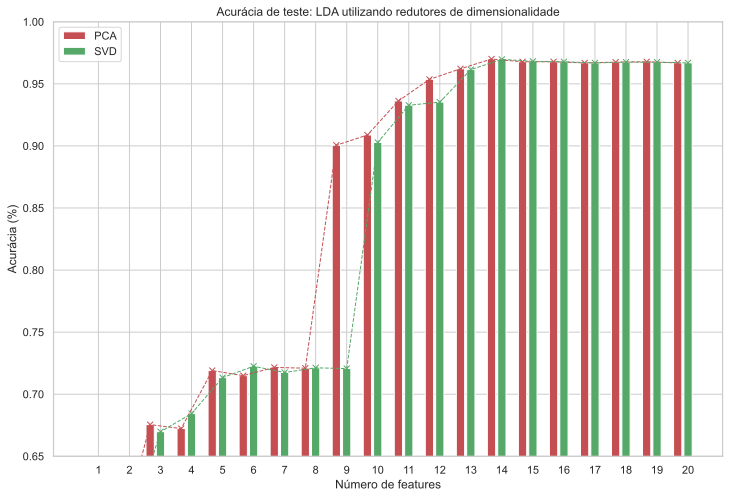

In [246]:
mean_scores = [[],[]]
results = np.array(results_LDA["mean_test_acc"])
results = results.reshape(-1, len(N_FEATURES_OPTIONS))
mean_scores[0] = np.append(results[0], accs_lda[1])
mean_scores[1] = np.append(results[1], accs_lda[1])

plt.figure(figsize=(12,8))
COLORS = ["r", "g"]

bar_offsets = np.arange(len(N_FEATURES_OPTIONS)+1) * (len(reducer_labels) + 1) + 0.5


## PLOT 
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.plot(bar_offsets+i, reducer_scores, color=COLORS[i], linestyle='dashed',marker='x', linewidth=1)
    
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets+i, reducer_scores, label=label, color=COLORS[i])

plt.title("Acurácia de teste: LDA utilizando redutores de dimensionalidade")
plt.xlabel("Número de features")
plt.xticks(bar_offsets + len(reducer_labels) / 2,np.append(N_FEATURES_OPTIONS, 20))
plt.ylabel("Acurácia (%)")
plt.ylim((0.65, 1))
plt.legend(loc="upper left")

plt.show()

##### Estas representações gráficas nos mostram que a diferença entre PCA e SVD não são significativas até aproximadamente 12 features. Analisando a tabela cv_results_ confirmamos essa hipótese.
##### Para o melhor redutor, PCA, poodemos notar também que há uma queda significativa da acurácia para um número de features menor que 11. Isto é, muitas dessas caracteristica apresentam alta correlação ou são irrelevantes para o problema. 
##### Para 14 features utilizadas a acurácia obtida é até maior do que com 20 features. Entretanto, esse diferença é pouco significativa.

## SVM

##### O segundo classificador que utilizaremos será a SVM.

In [247]:
pipe = Pipeline(
    [
        ("reduce_dim", "passthrough"),
        ("scaler", StandardScaler()),
        ("classify", SVC(kernel='linear', C=10, gamma='scale')),
    ]
)

grid_SVM = GridSearchCV(pipe, param_grid=param_grid, scoring=scores, refit="acc", cv=cv, return_train_score=True)

##### A linha do modelo segue a mesma, mas agora o classificador é a SVM

In [248]:
grid_SVM.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=9, shuffle=True),
             estimator=Pipeline(steps=[('reduce_dim', 'passthrough'),
                                       ('scaler', StandardScaler()),
                                       ('classify',
                                        SVC(C=10, kernel='linear'))]),
             param_grid=[{'reduce_dim': [PCA(n_components=14),
                                         TruncatedSVD(n_components=15)],
                          'reduce_dim__n_components': [1, 2, 3, 4, 5, 6, 7, 8,
                                                       9, 10, 11, 12, 13, 14,
                                                       15, 16, 17, 18, 19]}],
             refit='acc', return_train_score=True,
             scoring={'acc': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score)})

In [249]:
results_SVM = pd.DataFrame(grid_SVM.cv_results_)
results_SVM[['params', 'param_reduce_dim__n_components','mean_train_acc', 'mean_train_f1','mean_test_acc','mean_test_f1']]

,params,param_reduce_dim__n_components,mean_train_acc,mean_train_f1,mean_test_acc,mean_test_f1
0,"{'reduce_dim': PCA(n_components=14), 'reduce_d...",1,0.518782,0.672186,0.518623,0.672122
1,"{'reduce_dim': PCA(n_components=14), 'reduce_d...",2,0.603693,0.587217,0.604800,0.588071
2,"{'reduce_dim': PCA(n_components=14), 'reduce_d...",3,0.683476,0.661151,0.683713,0.660713
3,"{'reduce_dim': PCA(n_components=14), 'reduce_d...",4,0.687501,0.666108,0.684035,0.664140
4,"{'reduce_dim': PCA(n_components=14), 'reduce_d...",5,0.746765,0.735504,0.744636,0.733557
5,"{'reduce_dim': PCA(n_components=14), 'reduce_d...",6,0.741398,0.731408,0.740532,0.730780
6,"{'reduce_dim': PCA(n_components=14), 'reduce_d...",7,0.750473,0.737546,0.748108,0.735333
7,"{'reduce_dim': PCA(n_components=14), 'reduce_d...",8,0.751815,0.739751,0.747478,0.735352
8,"{'reduce_dim': PCA(n_components=14), 'reduce_d...",9,0.911616,0.906711,0.910986,0.906034
9,"{'reduce_dim': PCA(n_components=14), 'reduce_d...",10,0.913589,0.908726,0.911299,0.906548


##### Na inserção do GridSearch não é possível inserir um número nulo para redução de dimensionalidade,i.e.,um treinamento com todas as 20 features.
##### Abaixo temos o treinamento com os folds estratificados de cv, seguidos de uma padronização dos dados e a classificação feita pelo SVM.
##### Separamos as acurácias de treino e teste

In [250]:
acc_folds_train = []
acc_folds_test = []

accs_svm = []
scaler = StandardScaler()

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train = scaler.fit_transform(X_train, y_train)
    X_test = scaler.transform(X_test)

    svm_ = SVC(kernel='linear', C=10, gamma='scale').fit(X_train,y_train)

    acc_folds_train.append(accuracy_score(y_train, svm_.predict(X_train)))
    acc_folds_test.append(accuracy_score(y_test, svm_.predict(X_test)))
    
accs_svm.append([acc_folds_train, acc_folds_test])
accs_svm = [np.mean(acc,axis=1) for acc in accs_svm][0]
accs_svm

array([0.97656257, 0.97474646])

##### Abaixo temos o um gráfico representando as acurácias da redução de dimensionalidade por PCA e SVD variando o número de features.

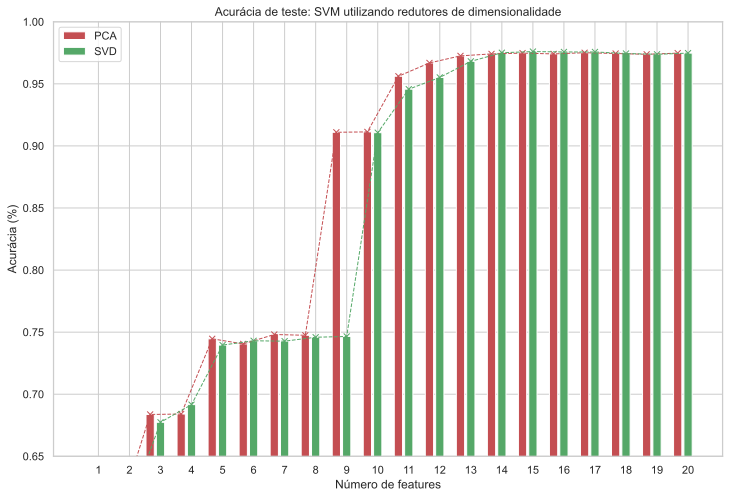

In [251]:
mean_scores = [[],[]]
results = np.array(results_SVM["mean_test_acc"])
results = results.reshape(-1, len(N_FEATURES_OPTIONS))
mean_scores[0] = np.append(results[0], accs_svm[1])
mean_scores[1] = np.append(results[1], accs_svm[1])

plt.figure(figsize=(12,8))
COLORS = ["r", "g"]
bar_offsets = np.arange(len(N_FEATURES_OPTIONS)+1) * (len(reducer_labels) + 1) + 0.5

## PLOT 
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.plot(bar_offsets+i, reducer_scores, color=COLORS[i], linestyle='dashed',marker='x', linewidth=1)
    
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets+i, reducer_scores, label=label, color=COLORS[i])

plt.title("Acurácia de teste: SVM utilizando redutores de dimensionalidade")
plt.xlabel("Número de features")
plt.xticks(bar_offsets + len(reducer_labels) / 2,np.append(N_FEATURES_OPTIONS, 20))
plt.ylabel("Acurácia (%)")
plt.ylim((0.65, 1))
plt.legend(loc="upper left")

plt.show()

##### Estas representações gráficas nos mostram que a diferença entre PCA e SVD não são significativas até aproximadamente 12 features. Analisando a tabela cv_results_ confirmamos essa hipótese.
##### Para o melhor redutor, PCA, poodemos notar também que há uma queda significativa da acurácia para um número de features menor que 11. Isto é, muitas dessas caracteristica apresentam alta correlação ou são irrelevantes para o problema. 


## Random Forest

##### Em seguida testaremos o Random Forest.

In [252]:
pipe = Pipeline(
    [
        ("reduce_dim", "passthrough"),
        ("scaler", StandardScaler()),
        ("classify", RandomForestClassifier()),
    ]
)
grid_RandomForest = GridSearchCV(pipe, param_grid=param_grid, scoring=scores, refit="acc", cv=cv, return_train_score=True)

In [ ]:
grid_RandomForest.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=9, shuffle=True),
             estimator=Pipeline(steps=[('reduce_dim', 'passthrough'),
                                       ('scaler', StandardScaler()),
                                       ('classify', RandomForestClassifier())]),
             param_grid=[{'reduce_dim': [PCA(n_components=18),
                                         TruncatedSVD(n_components=15)],
                          'reduce_dim__n_components': [1, 2, 3, 4, 5, 6, 7, 8,
                                                       9, 10, 11, 12, 13, 14,
                                                       15, 16, 17, 18, 19]}],
             refit='acc', return_train_score=True,
             scoring={'acc': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score)})

In [ ]:
results_RandomForest = pd.DataFrame(grid_RandomForest.cv_results_)
results_RandomForest[['params', 'param_reduce_dim__n_components','mean_test_acc','mean_test_f1']]

,params,param_reduce_dim__n_components,mean_test_acc,mean_test_f1
0,"{'reduce_dim': PCA(n_components=18), 'reduce_d...",1,0.554615,0.552970
1,"{'reduce_dim': PCA(n_components=18), 'reduce_d...",2,0.665085,0.659620
2,"{'reduce_dim': PCA(n_components=18), 'reduce_d...",3,0.731371,0.723492
3,"{'reduce_dim': PCA(n_components=18), 'reduce_d...",4,0.751263,0.744041
4,"{'reduce_dim': PCA(n_components=18), 'reduce_d...",5,0.821658,0.818125
5,"{'reduce_dim': PCA(n_components=18), 'reduce_d...",6,0.825133,0.821558
6,"{'reduce_dim': PCA(n_components=18), 'reduce_d...",7,0.839333,0.834124
7,"{'reduce_dim': PCA(n_components=18), 'reduce_d...",8,0.848810,0.845503
8,"{'reduce_dim': PCA(n_components=18), 'reduce_d...",9,0.931818,0.930118
9,"{'reduce_dim': PCA(n_components=18), 'reduce_d...",10,0.933079,0.931643


##### Na inserção do GridSearch não é possível inserir um número nulo para redução de dimensionalidade,i.e.,um treinamento com todas as 20 features.
##### Abaixo temos o treinamento com os folds estratificados de cv, seguidos de uma padronização dos dados e a classificação feita por Random Forest.
##### Separamos as acurácias de treino e teste

In [ ]:
acc_folds_train = []
acc_folds_test = []

accs_RandomForest = []
scaler = StandardScaler()

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train = scaler.fit_transform(X_train, y_train)
    X_test = scaler.transform(X_test)

    rfc_ = RandomForestClassifier().fit(X_train,y_train)

    acc_folds_train.append(accuracy_score(y_train, rfc_.predict(X_train)))
    acc_folds_test.append(accuracy_score(y_test, rfc_.predict(X_test)))
    
accs_RandomForest.append([acc_folds_train, acc_folds_test])
accs_RandomForest = [np.mean(acc,axis=1) for acc in accs_RandomForest][0]
accs_RandomForest

array([1.        , 0.97948331])

##### Abaixo temos o um gráfico representando as acurácias da redução de dimensionalidade por PCA e SVD variando o número de features.

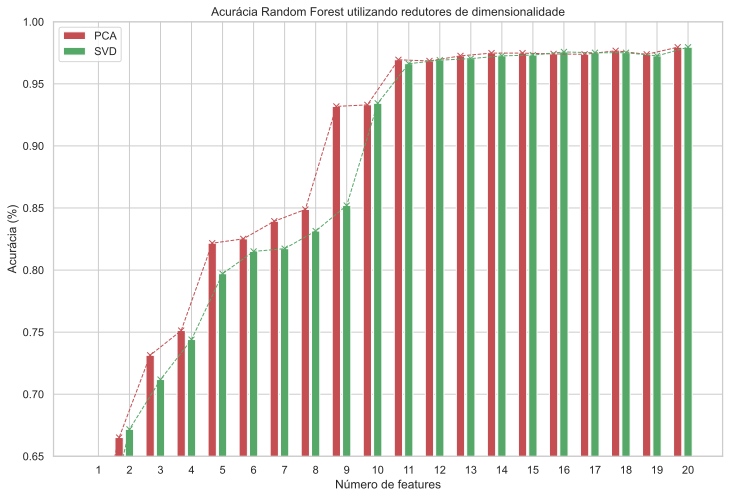

In [ ]:
mean_scores = [[],[]]
results = np.array(results_RandomForest["mean_test_acc"])
results = results.reshape(-1, len(N_FEATURES_OPTIONS))
mean_scores[0] = np.append(results[0], accs_RandomForest[1])
mean_scores[1] = np.append(results[1], accs_RandomForest[1])

plt.figure(figsize=(12,8))
COLORS = ["r", "g"]
bar_offsets = np.arange(len(N_FEATURES_OPTIONS)+1) * (len(reducer_labels) + 1) + 0.5

## PLOT 
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.plot(bar_offsets+i, reducer_scores, color=COLORS[i], linestyle='dashed',marker='x', linewidth=1)
    
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets+i, reducer_scores, label=label, color=COLORS[i])

plt.title("Acurácia Random Forest utilizando redutores de dimensionalidade")
plt.xlabel("Número de features")
plt.xticks(bar_offsets + len(reducer_labels) / 2,np.append(N_FEATURES_OPTIONS, 20))
plt.ylabel("Acurácia (%)")
plt.ylim((0.65, 1))
plt.legend(loc="upper left")

plt.show()

##### Estas representações gráficas nos mostram que a diferença entre PCA e SVD não são significativas até aproximadamente 9 features. Analisando a tabela cv_results_ confirmamos essa hipótese.
##### Para o melhor redutor, PCA, poodemos notar também que há uma queda significativa da acurácia para um número de features menor que 10. Isto é, muitas dessas caracteristica apresentam alta correlação ou são irrelevantes para o problema. 

# CONCLUSÃO

##### O método de redução de dimensionalidade SVD mostrou ter resultados mais ajustados para um classificação por SVM ou Random Forest.
##### Já o PCA apresentou maior robustez que o SVD e é a melhor escolha para todos os cenários testados.

<br>

##### No geral todos os métodos mostraram resultados acima de 90% para uma redução de dimensionalidade pela metade, de 20 para 10 features, feita tanto pelo PCA quanto pelo SVD.
##### Random Forest apresentou maior resistência a diminuição de features, apresentando resultados de acurácia superiores a 80%, em conjunto do PCA, para até 5 features. Enquanto os demais passavam desse limiar a partir de 9 features.
##### Para um numero maior do que 12 features a diferença entre os classificadores é marginal.
##### Somando todos esses fatores, é possível afirmar que Random Forest é o classificador mais adequado para este problema.



## NN

##### Observamos que este problema pode ser resolvido satisfatoriamente pelos classificadores desenvolvidos.

##### Porém, como exercício aplicaremos uma MLP no cenário em que ocorre a queda de desempenho significativa dentre todos os classificadores, o cenário de 8 features. Onde LDA e SVM possuem desempenho inferior a 75% e Random forest à 85%.

##### Utilizaremos o método de redução mais eficiente, PCA.

##### Importante salientar que chamadas a função fit ignoram a iteração passadas. FONTE: https://scikit-learn.org/stable/developers/develop.html#fitting

In [ ]:
accs = []
acc_folds_train = []
acc_folds_test = []
pca = PCA(n_components=8)

for i in range(1,21):
    for j in range(0,21):
        print(f'iteration {i}.{j}...')
        acc_folds_train = []
        acc_folds_test = []
        for train_index, test_index in cv.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform (X_test)
            
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train, y_train)
            X_test = scaler.transform(X_test)
            if(j>0):
                ANN = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(i,j), max_iter=2000).fit(X_train,y_train)
            else:
                ANN = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(i), max_iter=2000).fit(X_train,y_train)
            
            acc_folds_train.append(accuracy_score(y_train, ANN.predict(X_train)))
            acc_folds_test.append(accuracy_score(y_test, ANN.predict(X_test)))
        accs.append([acc_folds_train, acc_folds_test])

##### Abaixo separaremos os resultados das acurácias de treino e teste.

In [28]:
accs_mlp = [np.mean(acc,axis=1) for acc in accs]
acc_train = []
acc_test = []
for i in range(len(accs_mlp)):
    acc_train.append(accs_mlp[i][0])
    acc_test.append(accs_mlp[i][1])

##### É possível ver pelas warnings dados para o conjunto de camadas que boa parte das combinações com muitos neurônios não convergiu.

##### Para a visualização dos resultados da MLP, tendo duas camadas, será mostrado uma matriz bidimensional.

In [29]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels(labels=[i for i in range(data.shape[1])])
    ax.set_yticklabels(labels=[i for i in range(1,data.shape[0]+1)])

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1])-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0])-.5, minor=True)
    ax.grid(which="minor", color="w", linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


##### Abaixo temos as acurácias de treino e teste para a combinação exaustiva de até 20 neurônios na primeira e segunda camada.

[]

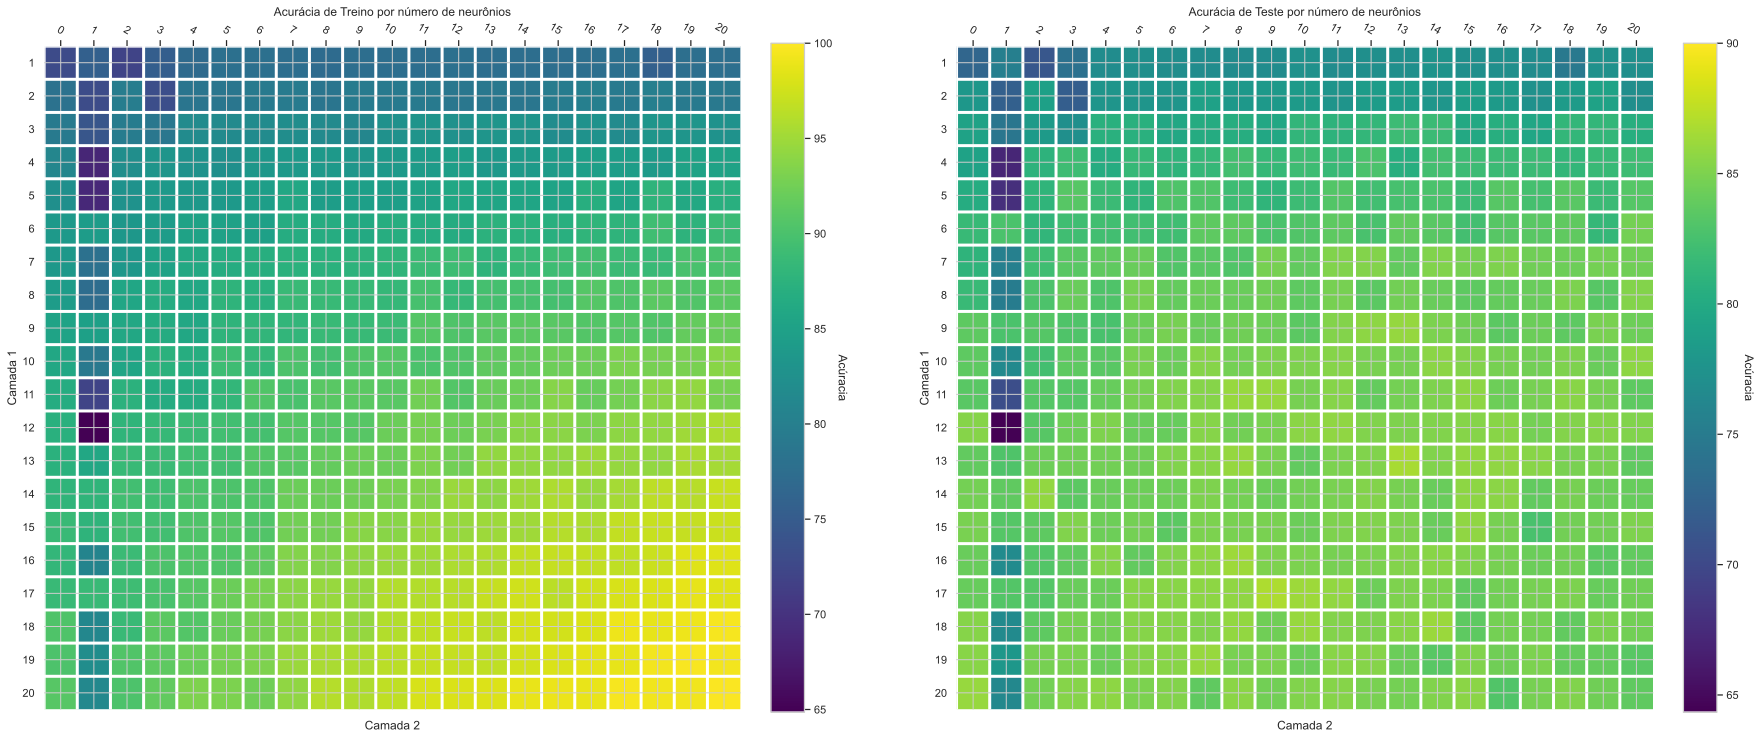

In [294]:
fig, [ax1,ax2] = plt.subplots(nrows=1, ncols=2)

im, cbar = heatmap(np.array(acc_train).reshape(20,21)*100, range(1,21), range(0,21), ax=ax1,
                   cbar_kw={"fraction":0.044, "pad":0.04},cmap="viridis", cbarlabel="Acúracia", vmax=100)

im, cbar = heatmap(np.array(acc_test).reshape(20,21)*100, range(1,21), range(0,21), ax=ax2,
                   cbar_kw={"fraction":0.044, "pad":0.04},cmap="viridis", cbarlabel="Acúracia", vmax=90)

plt.ylabel('Camada 1')
plt.xlabel('Camada 2')
# plt.title('Acurácia de treino por número de neurônios')
fig.set_size_inches(30,30)
ax1.set_title('Acurácia de Treino por número de neurônios')
ax2.set_title('Acurácia de Teste por número de neurônios')

ax1.set(xlabel='Camada 2', ylabel='Camada 1')
ax2.set(xlabel='Camada 2', ylabel='Camada 1')

ax1.label_outer()
ax2.label_outer()

plt.plot()

##### Podemos notar pelos gráficos que para uma combinação de 20 neurônios foi obtido a melhor classificação de teste, aproximadamente 85%, dentre as possibilidades testadas. Enquanto a acurácia de treino alcançou aproximadamente 90%.
#### Para combinações com mais neurônios a acurácia de teste permance a mesma porém a acurácia de teste aumenta, indicando overfit.

## REFERÊNCIAS

Lorem ipsum